# Regression Model on AirBnB Dataset- Location New York

**Dataset Description:
This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.

    id: listing ID
    name: name of the listing
    host_id: host ID
    host_name: name of the host
    neighbourhood_group: location
    neighbourhood: area
    latitude: latitude coordinates
    longitude: longitude coordinates
    room_type: listing space type
    price: price in dollars
    minimum_nights: amount of nights minimum
    number_of_reviews: number of reviews
    last_review:latest review
    reviews_per_month: number of reviews per month
    calculated_host_listings_count: amount of listing per host
    availability_365: number of days when listing is available for booking

Dataset Link: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

Included:
    1. Data Exploration
    2. Data Preprocessing
    3. Data Visualization
    4. Feature Selection
    5. Models
        a. Linear Regression:  with and without Grid Search, RepeatedStratifiedKFold for Cross Validation 
        b. KNN:   with and without Grid Search,  RepeatedStratifiedKFold for Cross Validation
        c. Stochastic Gradient Descent :  with and without  Grid Search, using RepeatedStratifiedKFold for Cross Validation
        d. Polynomial Regression:  with and without Grid Search, Cross Validation
        e. Ridge:  with and without Grid Search, Cross Validation
        f. Lasso:  with and without Grid Search, Cross Validation
        g. SVM with and without Kernel(rbf, poly, linear): with and without Grid Search, Cross Validation


Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold, RandomizedSearchCV, cross_validate,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import xgboost as xgb
import eli5

from sklearn.svm import SVR

Importing Dataset

In [2]:
df=pd.read_csv('AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

There are certain variable which do not contribute to the price of an AirBnB, So dropping them.

In [5]:
df.drop(['id','name','host_name','last_review'], axis=1, inplace=True)

In [6]:
df.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355


In [7]:
df.isnull().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#### Selecting Values which has price greater than 0 and are available to book

In [8]:
df=df[df['price']>0]
df = df[df['room_type'] != 0]
df = df[df['availability_365'] > 0]

In [9]:
df.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355


## Handing Missing Values

Creating a varible which shows median price of each neighbourhood

In [10]:
median_price_neigh = pd.DataFrame(df.groupby('neighbourhood')['price'].median()) 
df = df.join(median_price_neigh, on='neighbourhood', rsuffix='_median_neighbourhood')
df.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_median_neighbourhood
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,67.0
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,225.0


Plotting the number of AirBnB by neighbourhood_group

Text(0.5, 1.0, 'neighbourhood_group')

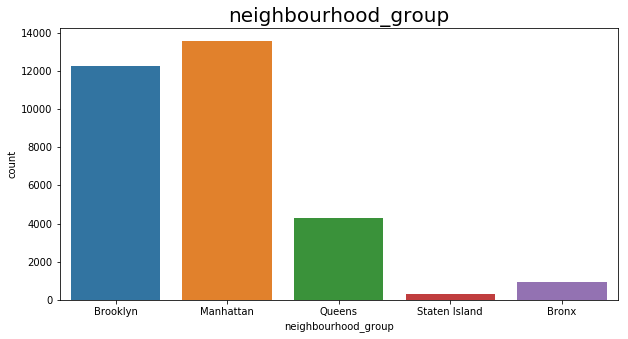

In [11]:
plt.figure(figsize=(10,5))
ax = sns.countplot(df["neighbourhood_group"])
plt.title('neighbourhood_group', fontsize=20)

PLotting the count of each room type with respect to neighbourhood_group

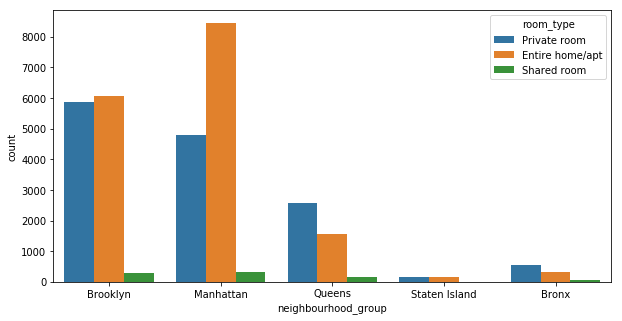

In [12]:
plt.figure(figsize=(10,5))
ax = sns.countplot(df['neighbourhood_group'],hue=df['room_type'])


Below Map shows the density of rooms available by rach neighbourhood group

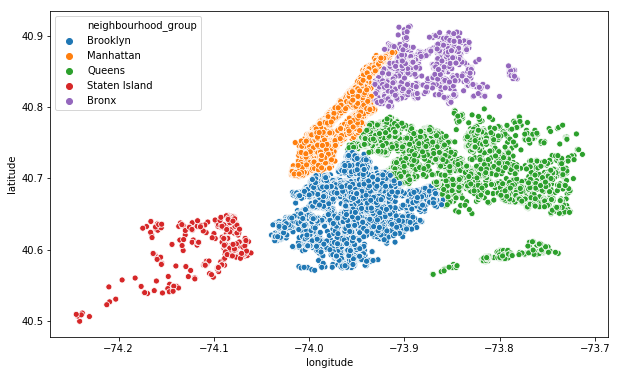

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group)
plt.ioff()

Creating a varible which shows median price of each neighbourhood group

In [14]:
median_price_neigh_gp = pd.DataFrame(df.groupby('neighbourhood_group')['price'].median()) 
df = df.join(median_price_neigh_gp, on='neighbourhood_group', rsuffix='_median_neighbourhood_group')
df.head(2)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_median_neighbourhood,price_median_neighbourhood_group
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,67.0,99
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,225.0,151


Copying the manipulated dataset into a new one

In [15]:
data=df.copy()

Creating dummy variables for neighbourhood_group and room_type as these two are of categorical variables with string type

In [16]:
data = pd.get_dummies(data=data, columns=['neighbourhood_group','room_type'])

In [17]:
data.head(2)

,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_median_neighbourhood,price_median_neighbourhood_group,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2787,Kensington,40.64749,-73.97237,149,1,9,0.21,6,365,67.0,99,0,1,0,0,0,0,1,0
1,2845,Midtown,40.75362,-73.98377,225,1,45,0.38,2,355,225.0,151,0,0,1,0,0,1,0,0


dropping neighbourhood as they have too many categories 

In [18]:
data.drop(["neighbourhood"], inplace = True, axis = 1)

Creating a correlation matrix to view corelation between variables to summarize data.
Key decisions to be made when creating a correlation matrix include: choice of correlation statistic, coding of the variables, treatment of missing data, and presentation.

Index(['host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'price_median_neighbourhood', 'price_median_neighbourhood_group',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

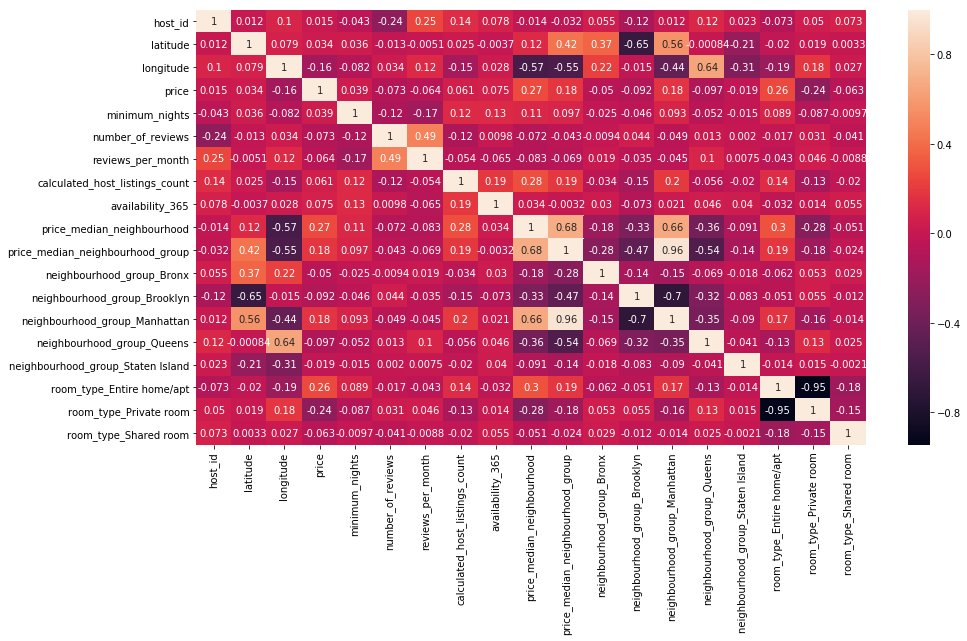

In [19]:
corr = data.corr(method = 'pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
data.columns

In [20]:
len(data.columns)

19

In [21]:
data=data.dropna()

Target Variable is Price

In [22]:
y=data['price']

In [23]:
x=data.loc[:, data.columns != 'price']

Splitting the data into test and train to run regression models

In [24]:
X_train_org, X_test_org, y_train, y_test = train_test_split(x,y, random_state = 0)

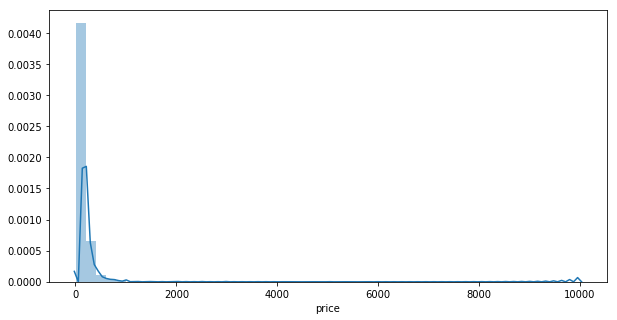

In [25]:
#Plot for average y value range
plt.figure(figsize=(10,5))
sns.distplot(y)

**Note:: As the dataset itself has very low quality variables to explain y variable more correctly, our output shows R2 very low and able to explain very less varience.

# Regression Models

### Linear Regressor

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

In [27]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()
lreg.fit(X_train, y_train)
print(lreg.score(X_train, y_train))
print(lreg.score(X_test, y_test))

0.14167663369403116
0.2684089132254591


Text(0.5, 0, 'RM')

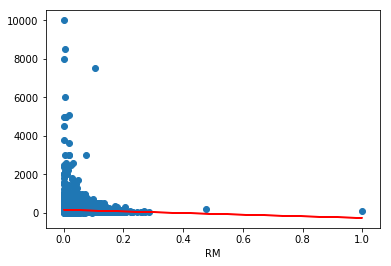

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

X_train_rm = X_train[:,5].reshape(-1,1)
lreg.fit(X_train_rm, y_train)
y_predict = lreg.predict(X_train_rm)

plt.plot(X_train_rm, y_predict, c = 'r')
plt.scatter(X_train_rm,y_train)
plt.xlabel('RM')

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

Linear Regression with grid search and RepeatedStratifiedKFold for cross validation

In [30]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
model = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=rskfold)
grid.fit(X_train, y_train)
print ("r2 / variance : ", grid.best_score_)
print("Residual sum of squares: %.2f"% np.mean((grid.predict(X_test) - y_test) ** 2))

r2 / variance :  0.15989688854791187
Residual sum of squares: 17231.31


In [31]:
warnings.filterwarnings("ignore")
grid.fit(X_test,y_test)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x0000015A99BE1AC8>,
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
grid.best_score_

0.27689688775405563

Text(0, 0.5, 'Mean Test Score')

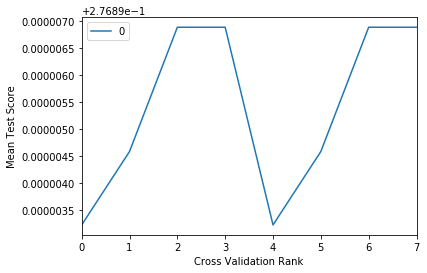

In [33]:
curve = pd.DataFrame(grid.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

### KNN Regressor

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train_org, X_test_org, y_train, y_test = train_test_split(x,y, random_state = 0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

Text(0, 0.5, 'MSE')

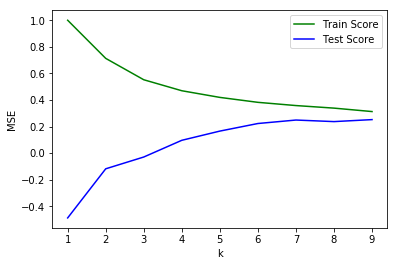

In [35]:
%matplotlib inline
train_score_array = []
test_score_array = []

for k in range(1,10):
    knn_reg = KNeighborsRegressor(k)
    knn_reg.fit(X_train, y_train)
    train_score_array.append(knn_reg.score(X_train, y_train))
    test_score_array.append(knn_reg.score(X_test, y_test))

x_axis = range(1,10)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('k')
plt.ylabel('MSE')

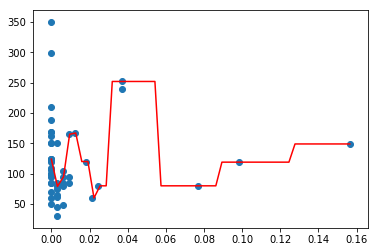

In [36]:
#CRIM and AGE
X_b = X_train[:50,6].reshape(-1,1)
y_b = y_train[:50]

knn_reg = KNeighborsRegressor(1)
knn_reg.fit(X_b, y_b)

X_new=np.linspace(X_b.min(), X_b.max(), 50).reshape(50, 1)
y_predict = knn_reg.predict(X_new)

plt.plot(X_new, y_predict, c = 'r')
plt.scatter(X_b, y_b)

KNN regression with grid search and RepeatedStratifiedKFold for cross validation

In [37]:
clf = KNeighborsRegressor()
param_dist = {"n_neighbors": [2,3,4],
              "leaf_size" : [20,30,40],
              'p' : [1,2,3] }
grid_search = GridSearchCV(clf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring="r2")

In [38]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40], 'n_neighbors': [2, 3, 4],
                         'p': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [39]:
grid_search.best_score_

0.13568994699991735

In [40]:
grid_search.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40], 'n_neighbors': [2, 3, 4],
                         'p': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [41]:
grid_search.best_score_

0.2422162032801373

Text(0, 0.5, 'Mean Test Score')

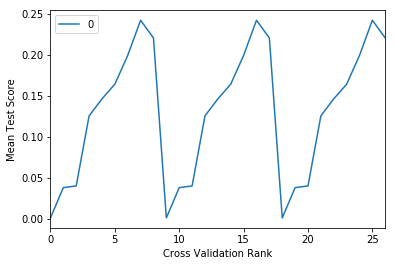

In [42]:
curve = pd.DataFrame(grid_search.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

In [43]:
#conda install scikit-learn

In [44]:
#plot.grid_search(grid_search.cv_results_, change='n_neighbors',kind='bar')

### SGD Regressor

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

In [46]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state= 0, max_iter = 100000, learning_rate = 'optimal', penalty = 'l2')
sgd_reg.fit(X_train, y_train)
print(sgd_reg.score(X_train, y_train))
print(sgd_reg.score(X_test, y_test))

0.07738160708107722
0.13210204321132646


In [47]:
sgd_reg.coef_

array([ -3.95595634,  24.20109022,  -9.79742045,  -8.86628666,
        -0.21514807,  -6.53981812,  -3.50816875,  49.10998336,
        51.11211194,   2.61297482, -16.18498886,  11.35635534,
        -2.01473886,   0.49537716, -19.73546605,  39.77306013,
       -36.3274228 , -11.55126847])

In [48]:
sgd_reg.intercept_

array([165.27743287])

In [49]:
sgd_reg.n_iter_

39

SGD using GridSearch and Cross Validation

In [50]:
model = SGDRegressor()
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(model, param_grid,cv=5)
clf.fit(X_train, y_train)
print("Best score: " + str(clf.best_score_))

Best score: 0.17121664745201876


In [51]:
warnings.filterwarnings("ignore")
clf.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_loss', 'huber'

In [52]:
clf.best_score_

0.2745330594037474

Text(0, 0.5, 'Mean Test Score')

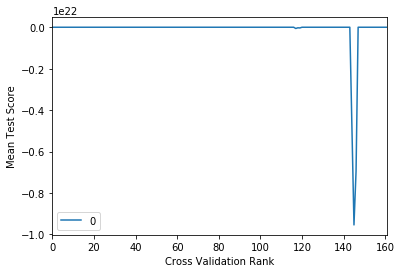

In [53]:
curve = pd.DataFrame(clf.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

### Polynomial regression

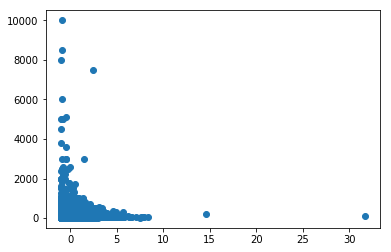

In [54]:
from  sklearn.preprocessing  import PolynomialFeatures

X_train_1 = X_train[:,5].reshape(-1,1)
plt.scatter(X_train_1,y_train)

In [55]:
train_score_list = []
test_score_list = []

for n in range(1,3):
    poly = PolynomialFeatures(n)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    lreg.fit(X_train_poly, y_train)
    train_score_list.append(lreg.score(X_train_poly, y_train))
    test_score_list.append(lreg.score(X_test_poly, y_test))

In [56]:
print(train_score_list)
print(test_score_list)

[0.14167664302205074, 0.1672436501753719]
[0.26840051925764763, 0.2897806891185559]


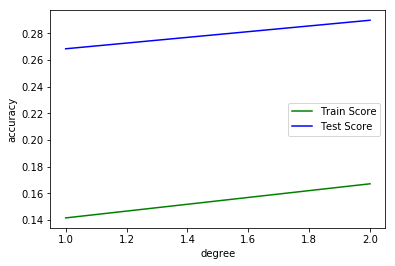

In [57]:
%matplotlib inline

x_axis = range(1,3)
plt.plot(x_axis, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_list, c = 'b', label = 'Test Score')
plt.xlabel('degree')
plt.ylabel('accuracy')
plt.legend()

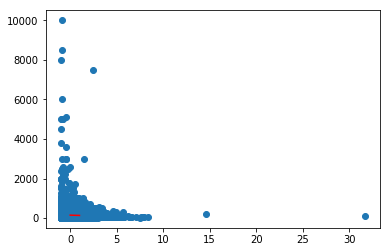

In [58]:
poly = PolynomialFeatures(n)
X_train_poly = poly.fit_transform(X_train_1)
lreg.fit(X_train_poly, y_train)

x_axis = np.linspace(0,1,100).reshape(-1,1)
x_poly = poly.transform(x_axis)
y_predict = lreg.predict(x_poly)

X_train_1 = X_train[:,5].reshape(-1,1)
plt.scatter(X_train_1,y_train)
plt.plot(x_axis, y_predict, c = 'r')

Polynomial Regression using Grid search

In [59]:
poly = PolynomialFeatures()
x_poly_train = poly.fit_transform(X_train) 
x_poly_test = poly.fit_transform(X_test)
model_LinReg2 = LinearRegression()

In [60]:
model_svm = SVR(gamma = 'scale')
param_svm = {"C": [0.1, 0.5, 1], "epsilon" : [0.1, 0.2, 0.3]}
grid_search_svm = GridSearchCV(model_svm, n_jobs=-1, param_grid=param_svm, 
                           cv = 3, scoring="r2")
grid_search_svm.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'epsilon': [0.1, 0.2, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [61]:
grid_search_svm.best_score_
#poly_grid.fit(X_test,y_test)

0.11467812872562293

In [62]:
grid_search_svm.best_params_

{'C': 1, 'epsilon': 0.3}

In [63]:
grid_search_svm.fit(X_test,y_test)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'epsilon': [0.1, 0.2, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [64]:
grid_search_svm.best_score_

0.17620493214429866

Text(0, 0.5, 'Mean Test Score')

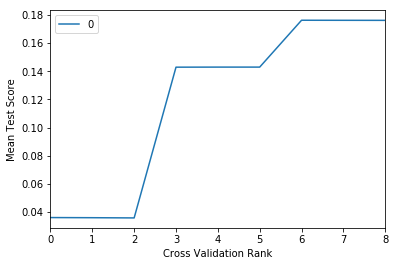

In [65]:
curve = pd.DataFrame(grid_search_svm.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

### Ridge

In [66]:
from  sklearn.linear_model import Ridge

x_range = [0.01, 0.1, 1, 10, 100]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    ridge = Ridge(alpha)
    ridge.fit(X_train,y_train)
    train_score_list.append(ridge.score(X_train,y_train))
    test_score_list.append(ridge.score(X_test, y_test))

Text(0.5, 0, '$\\alpha$')

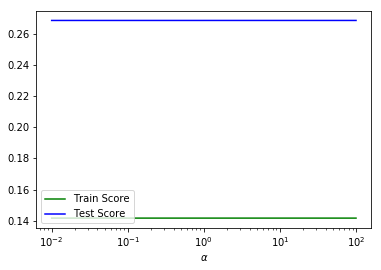

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

In [68]:
print(train_score_list)
print(test_score_list)

[0.14167663369398809, 0.1416766336897124, 0.14167663326229962, 0.14167659067523009, 0.14167248009352607]
[0.2684089143779014, 0.26840892474165234, 0.26840902756478446, 0.26840997468071626, 0.2684116442614981]


In [69]:
ridge = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge.fit(X_train,y_train)
print('Train score: {:.4f}'.format(ridge.score(X_train,y_train)))
print('Test score: {:.4f}'.format(ridge.score(X_test, y_test)))

Train score: 0.1417
Test score: 0.2684


In [70]:
ridge.coef_

array([  5.2958413 ,   6.14301932,  -3.05446301,  -7.81625452,
        -9.07702919,  -4.22454654,  -7.50461164,  19.32236999,
        46.19645622,   0.11567057,  -3.17610558,   1.57636409,
        -0.51525022,   0.70575193,  -2.25498199,  26.6469853 ,
       -22.9612326 , -12.17488018])

In [71]:
ridge.intercept_

150.49036206017337

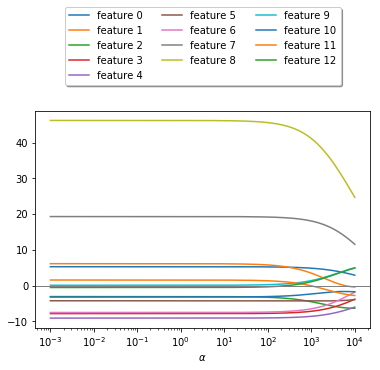

In [72]:
%matplotlib inline
import numpy as np

x_range1 = np.linspace(0.001, 1, 100).reshape(-1,1)
x_range2 = np.linspace(1, 10000, 10000).reshape(-1,1)

x_range = np.append(x_range1, x_range2)
coeff = []

for alpha in x_range: 
    ridge = Ridge(alpha)
    ridge.fit(X_train,y_train)
    coeff.append(ridge.coef_ )

coeff = np.array(coeff)

for i in range(0,13):
    plt.plot(x_range, coeff[:,i], label = 'feature {:d}'.format(i))

plt.axhline(y=0, xmin=0.001, xmax=9999, linewidth=1, c ='gray')
plt.xlabel(r'$\alpha$')
plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),ncol=3, fancybox=True, shadow=True)
plt.show()

Ridge Regression Using Grid Search and cross validation

In [73]:
param1 = {"alpha": [0.1,0.5,1]}
ridge =  Ridge(alpha)
grid_search1 = GridSearchCV(ridge, n_jobs=-1, param_grid=param1, 
                           cv = 5, scoring="r2")
grid_search1.fit(X_train,y_train)
grid_search1.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [74]:
grid_search1.best_score_

0.1714240322114804

In [75]:
grid_search1.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=10000.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1, param_grid={'alpha': [0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [76]:
grid_search1.best_score_

0.2739154789135986

Text(0, 0.5, 'Mean Test Score')

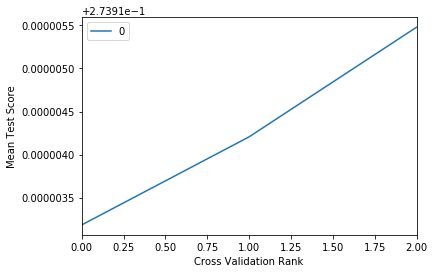

In [77]:
curve = pd.DataFrame(grid_search1.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

### LASSO


In [78]:
from sklearn.linear_model import Lasso
x_range = [0.01, 0.1, 1, 10, 100]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    lasso = Lasso(alpha)
    lasso.fit(X_train,y_train)
    train_score_list.append(lasso.score(X_train,y_train))
    test_score_list.append(lasso.score(X_test, y_test))

Text(0.5, 0, '$\\alpha$')

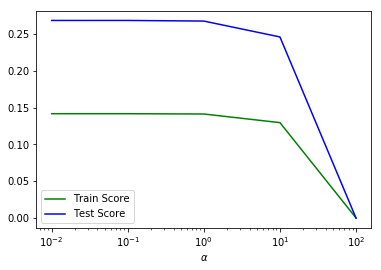

In [79]:
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

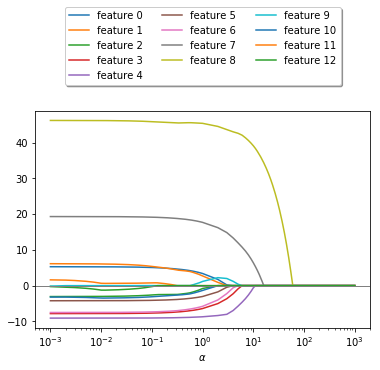

In [80]:
%matplotlib inline

x_range1 = np.linspace(0.001, 1, 1000).reshape(-1,1)
x_range2 = np.linspace(1, 1000, 1000).reshape(-1,1)

x_range = np.append(x_range1, x_range2)
coeff = []

for alpha in x_range: 
    lasso = Lasso(alpha)
    lasso.fit(X_train,y_train)
    coeff.append(lasso.coef_ )
    
coeff = np.array(coeff)

for i in range(0,13):
    plt.plot(x_range, coeff[:,i], label = 'feature {:d}'.format(i))

plt.axhline(y=0, xmin=0.001, xmax=9999, linewidth=1, c ='gray')
plt.xlabel(r'$\alpha$')
plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=3, fancybox=True, shadow=True)
plt.show()

Lasso Regression using Grid Search and cross validation

In [81]:
model2 = Lasso()
param1 = {"alpha": [0.1,0.5,1]}
grid_search2 = GridSearchCV(model2, n_jobs=-1, param_grid=param1, 
                           cv = 5, scoring="r2")
grid_search2.fit(X_train,y_train)
grid_search2.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [82]:
grid_search2.best_score_

0.17141783011662226

In [83]:
grid_search2.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'alpha': [0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [84]:
grid_search2.best_score_

0.2739891732444591

Text(0, 0.5, 'Mean Test Score')

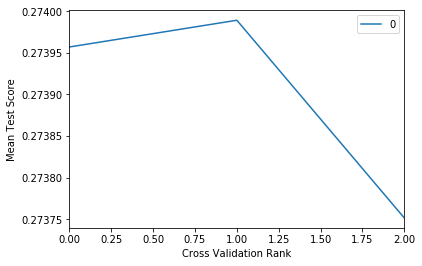

In [85]:
curve = pd.DataFrame(grid_search2.cv_results_['mean_test_score'])
curve.plot()
plt.xlabel('Cross Validation Rank')
plt.ylabel('Mean Test Score')

### XGBoost

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [86]:
xg_reg=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[22:45:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 146.861256


## SVM Models

Cross Validate all the SVM Models

In [88]:
from sklearn.svm import SVR

reg = [
    SVR(gamma='scale', C=1.0, epsilon=0.2),
    SVR(kernel='linear', C=100, gamma='auto', epsilon = 0.2),
    SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)]

reg_names = [
    "SVM Simple",
    "SVM Linear Kernel",
    "SVM Poly Kernel"]

In [89]:
scores = np.zeros(len(reg))
scores_test = np.zeros(len(reg))
scores_final = np.zeros(len(reg))

In [90]:
for i in np.arange(len(reg)):
    print(reg_names[i])
    scores[i] = np.mean(cross_validate(reg[i], X_train, y_train, 
                                       scoring="r2", 
                                       cv=3)["test_score"])

SVM Simple
SVM Linear Kernel
SVM Poly Kernel


In [91]:
#pd.DataFrame(scores, index=reg_names, columns=["Score"])
pd.DataFrame(scores, index=reg_names, columns=["Train_Score"])

,Train_Score
SVM Simple,0.114658
SVM Linear Kernel,0.114931
SVM Poly Kernel,0.119510


In [92]:
for i in np.arange(len(reg)):
    print(reg_names[i])
    scores_test[i] = np.mean(cross_validate(reg[i], X_test, y_test,  scoring="r2",  cv=3)["test_score"])

SVM Simple
SVM Linear Kernel
SVM Poly Kernel


In [93]:
pd.DataFrame(scores_test, index=reg_names, columns=["Test_Score"])

,Test_Score
SVM Simple,0.176159
SVM Linear Kernel,0.209215
SVM Poly Kernel,0.222790


# Model Predictions

**After running all the model above and finding the test and train scores, I am listing them down for comparison.

Model Name  |    Test score  |  Train Score

   linear         0.15989         0.2769
    KNN           0.13568         0.2422
    SGD           0.17180         0.2750
  Polynomial      0.11467         0.1762
    Ridge         0.17142         0.2739
   Lasso          0.17141         0.2739
   
Comparing all the above model's test and train score, We came to the conclusion that SGD gives better performance than others than slight margin.

**Note: Since all the models are performing poorly we can say that we need different variables in the dataset which may be able to explain the pricing better. 
Additionally we could also try boosting and Neural networks to give better predictions. Which will be continued in project 2.


Predicting the price using SGD

In [94]:
y_pred = clf.predict(X_test)

In [95]:
df1=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head()

,Actual,Predicted
16131,125,164.339312
31497,60,148.492640
2765,49,66.779881
33787,115,165.296870
21186,174,114.302403


In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
#Method for calculating r-squared value and RMSE
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
test_set_r2 = r2_score(y_test, y_pred)
print ('test_set_r2 = ',test_set_r2,'test_set_rmse= ',test_set_rmse) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

test_set_r2 =  0.2680706664531398 test_set_rmse=  131.29843592875795
Mean Absolute Error: 64.07450575942671


**References:

1. O'reilly Hands-on Machine Learning with Scikit-Learn & TensorFlow by Aurelieb Geron
2. https://www.kaggle.com/
3. Git Hut Machine Learning projects
4. StackOverflow.com